In [13]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.font_manager as fm
import matplotlib.ticker as mticker

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

from datetime import datetime

In [14]:
class PlotData:
   
    def __init__(self):
        
        self.export_img = "../../report/img"
        self.processed_folder = "../../data/processed"

        os.makedirs(self.export_img, exist_ok=True)

    def plot_fiveyr_seasonal(self, file_import_name, chart_title, size, legend=None):

        # Import Data

        file_path_import = os.path.join(self.processed_folder, file_import_name)
        df = pd.read_csv(file_path_import)

        # Cleaning the Data

        # Rename the columns for easier access
        df.columns = ['Date', 'Data']

        # Convert 'Date' column to datetime format
        df['Date'] = pd.to_datetime(df['Date'])

        # Extract week number, month, and year
        df['Week_Num'] = df['Date'].dt.isocalendar().week
        df['Month'] = df['Date'].dt.month
        df['Year'] = df['Date'].dt.year

        # Pivot the Data

        # Pivot the DataFrame to have Week_Num as rows, Year as columns, and Data as values
        pivoted_df = df.pivot_table(index='Week_Num', columns='Year', values='Data')
        
        # Sort the columns to have years starting from the newest
        pivoted_df = pivoted_df.sort_index(axis=1, ascending=False)

        pivoted_df = pivoted_df.iloc[:,:6]

        fiveYearsRange = pivoted_df

        # Calculate the 5-year max, min, and average for each row
        pivoted_df["5YrMax"] = fiveYearsRange.max(axis=1)
        pivoted_df["5YrMin"] = fiveYearsRange.min(axis=1)
        pivoted_df["5YrAvg"] = fiveYearsRange.mean(axis=1)

        # Plot the Data

        # Paths to your Montserrat font files
        font_path = '../assets/Montserrat/static/Montserrat-Regular.ttf'
        font_path_bold = '../assets/Montserrat/static/Montserrat-Black.ttf'
        
        # Register the font properties
        prop = fm.FontProperties(fname=font_path)
        prop_black = fm.FontProperties(fname=font_path_bold)

        pivot_dataset = pivoted_df

        # Ensure plot_data is sorted by index (Week)
        plot_data = pivot_dataset.sort_index()

        # Create a numerical range for the x-axis based on the length of the DataFrame
        x_values = np.arange(len(plot_data)) + 1

        # Size Chart
        plt.figure(figsize=(size[0], size[1]))  # Adjusted height for better visibility

        # Plot the 5-Year Max/Min range as a shaded area
        plt.fill_between(x_values, plot_data['5YrMax'], plot_data['5YrMin'], color='lightgray', label='5-Year Range')

        # Colors
        fiveYear_avgColor = "black"
        fiveYear_PrevYrColor = "#FFA500"
        fiveYear_CurrentYrColor = "#003366"

        # Years

        current_yr = datetime.now().year
        previous_yr = current_yr - 1

        # Plot 5-Year Average and actual values
        plt.plot(plot_data.index, plot_data['5YrAvg'], color=fiveYear_avgColor, linestyle='--', label='5-Year Average', linewidth=1)
        plt.plot(plot_data.index, plot_data[previous_yr], color=fiveYear_PrevYrColor, label=f'{previous_yr}', linewidth=1.5, alpha=0.7)
        plt.plot(plot_data.index, plot_data[current_yr], color=fiveYear_CurrentYrColor, marker='o', label=f'{current_yr}', linewidth=2)

         # Format y-axis values
        def thousands(x, pos):
            """Format the y-axis values with a dot as the thousand separator."""
            return f'{x/1000:,.2f}'.replace(',', '.')
        plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(thousands))
        
        y_label = "Million Barrels"

        if legend == None:
        
            plt.title(f'{chart_title}', fontproperties=prop_black, size=20, pad=10)  # Larger title with size specified in title
            plt.xlabel("Week", fontproperties=prop, size=14)  # Larger x-label
            plt.ylabel(y_label, fontproperties=prop, size=14)  # Larger y-label

            # Place legend with regular font
            plt.legend(loc='lower right', prop=prop)
        
        else:

            plt.title(f'{chart_title}', fontproperties=prop_black, size=12, pad=10)  # Larger title with size specified in title
            plt.xlabel("Week", fontproperties=prop, size=12)  # Larger x-label
            plt.ylabel(y_label, fontproperties=prop, size=12)  # Larger y-label

        plt.grid(True, linestyle='--', alpha=0.6)  # Add consistent grid style
        plt.tight_layout()

        # Save the plot as a PNG file
        export_file_name = f'{chart_title}'.replace(" ", "").replace("-", "") + ".png"
        export_file_path = os.path.join(self.export_img, export_file_name)

        os.makedirs(self.export_img, exist_ok=True)
        plt.savefig(export_file_path, bbox_inches='tight')

        # Show the plot
        plt.show()

        return pivoted_df
    
    def poly_calc(self, file_import_name, chart_title, size):
        
        # Import Data

        file_path_import = os.path.join(self.processed_folder, file_import_name)
        df = pd.read_csv(file_path_import)

        # Cleaning the Data

        # Rename the columns for easier access
        df.columns = ['Date', 'Data']

        # Convert 'Date' column to datetime format
        df['Date'] = pd.to_datetime(df['Date'])

        # Extract week number, month, and year
        df['Week_Num'] = df['Date'].dt.isocalendar().week
        df['Month'] = df['Date'].dt.month
        df['Year'] = df['Date'].dt.year

        # Pivot the Data

        # Pivot the DataFrame to have Week_Num as rows, Year as columns, and Data as values
        pivoted_df = df.pivot_table(index='Week_Num', columns='Year', values='Data')
        
        # Sort the columns to have years starting from the newest
        pivoted_df = pivoted_df.sort_index(axis=1, ascending=False)

        pivoted_df = pivoted_df.iloc[:,:6]

        data = pivoted_df

        # Ensure the length of x_date and y_num are the same
        x_date = data.index.values.reshape(-1, 1)

        current_year = datetime.now().year
        prev_year = current_year - 1
        prev_prev_year = current_year - 2

        # Current year
        y_num = pivoted_df[current_year].values

        # Filter out NaN values for fitting
        valid_idx = ~np.isnan(y_num)  # Boolean index for non-NaN values
        x_date_valid = x_date[valid_idx]
        y_num_valid = y_num[valid_idx]

        # Create polynomial features
        poly = PolynomialFeatures(degree=3)
        x_poly = poly.fit_transform(x_date)

        # Fit the linear regression model using valid (non-NaN) data
        model = LinearRegression()
        model.fit(x_poly[valid_idx], y_num_valid)  # Fit only on valid data points

        # Make predictions using the model
        y_pred_curryr = model.predict(x_poly)

        # Mask predictions for NaN values
        y_pred_curryr_with_na = np.where(np.isnan(y_num), np.nan, y_pred_curryr)
        
        # Previous Year

        # Fill missing values in y_num with NaN for visualization purposes
        y_num = data[prev_year].values
        y_num_filled = y_num.copy()
        y_num_filled[np.isnan(y_num)] = np.nan  # Explicitly set NaN for missing values

        # Create polynomial features
        poly = PolynomialFeatures(degree=3)
        x_poly = poly.fit_transform(x_date)

        # Fit the linear regression model (use filled values)
        model = LinearRegression()
        model.fit(x_poly[~np.isnan(y_num)], y_num[~np.isnan(y_num)])  # Fit only on valid data points

        # Make predictions
        y_pred_prevyr = model.predict(x_poly)

        # Previous Previous Year

        # Fill missing values in y_num with NaN for visualization purposes
        y_num = data[prev_prev_year].values
        y_num_filled = y_num.copy()
        y_num_filled[np.isnan(y_num)] = np.nan  # Explicitly set NaN for missing values

        # Create polynomial features
        poly = PolynomialFeatures(degree=3)
        x_poly = poly.fit_transform(x_date)

        # Fit the linear regression model (use filled values)
        model = LinearRegression()
        model.fit(x_poly[~np.isnan(y_num)], y_num[~np.isnan(y_num)])  # Fit only on valid data points

        # Make predictions
        y_pred_prevprevyr = model.predict(x_poly)
        
        poly_dataset = pd.DataFrame([y_pred_curryr_with_na, y_pred_prevyr, y_pred_prevprevyr], index=[f'poly_{current_year}', f'poly_{prev_year}', f'poly_{prev_prev_year}']).T
        poly_dataset.index = range(1, len(poly_dataset) + 1)

        print(poly_dataset)
        
        # Ploting Chart

        fiveYearsRange = pivoted_df

        # Calculate the 5-year max, min, and average for each row
        pivoted_df["5YrMax"] = fiveYearsRange.max(axis=1)
        pivoted_df["5YrMin"] = fiveYearsRange.min(axis=1)
        pivoted_df["5YrAvg"] = fiveYearsRange.mean(axis=1)

        # Plot the Data

        # Paths to your Montserrat font files
        font_path = '../assets/Montserrat/static/Montserrat-Regular.ttf'
        font_path_bold = '../assets/Montserrat/static/Montserrat-Black.ttf'
        
        # Register the font properties
        prop = fm.FontProperties(fname=font_path)
        prop_black = fm.FontProperties(fname=font_path_bold)

        pivot_dataset = pivoted_df

        # Ensure plot_data is sorted by index (Week)
        plot_data = pivot_dataset.sort_index()

        # Create a numerical range for the x-axis based on the length of the DataFrame
        x_values = np.arange(len(plot_data)) + 1

        # Size Chart
        plt.figure(figsize=(size[0], size[1]))  # Adjusted height for better visibility

        # Plot the 5-Year Max/Min range as a shaded area
        plt.fill_between(x_values, plot_data['5YrMax'], plot_data['5YrMin'], color='lightgray', label='5-Year Range')

        # Colors
        PrevPrevYrColor = "#7F588E"
        PrevYrColor = "#FFA500"
        CurrentYrColor = "#003366"

        # Years

        # Plot 5-Year Average and actual values
        plt.plot(poly_dataset.index, poly_dataset[f"poly_{prev_prev_year}"], color=PrevPrevYrColor, label=f'Poly. {prev_prev_year}', linewidth=1.5, alpha=0.7)
        plt.plot(poly_dataset.index, poly_dataset[f"poly_{prev_year}"], color=PrevYrColor, label=f'Poly. {prev_year}', linewidth=1.5, alpha=0.7)
        plt.plot(poly_dataset.index, poly_dataset[f"poly_{current_year}"], color=CurrentYrColor, label=f'Poly. {current_year}', linewidth=1.5, alpha=0.7)

                 # Format y-axis values
        def thousands(x, pos):
            """Format the y-axis values with a dot as the thousand separator."""
            return f'{x/1000:,.0f}'.replace(',', '.')
        plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(thousands))
        
        y_label = "Million Barrels"

        plt.title(f'{chart_title}', fontproperties=prop_black, size=20, pad=10)  # Larger title with size specified in title
        plt.xlabel("Week", fontproperties=prop, size=14)  # Larger x-label
        plt.ylabel(y_label, fontproperties=prop, size=14)  # Larger y-label

        # Place legend with regular font
        plt.legend(loc='lower right', prop=prop)

        plt.grid(True, linestyle='--', alpha=0.6)  # Add consistent grid style
        plt.tight_layout()

        # Save the plot as a PNG file
        export_file_name = f'{chart_title}'.replace(" ", "").replace("-", "") + ".png"
        export_file_path = os.path.join(self.export_img, export_file_name)

        os.makedirs(self.export_img, exist_ok=True)
        plt.savefig(export_file_path, bbox_inches='tight')

        # Show the plot
        plt.show()

        return poly_dataset
    
    def z_score_calc(self, file_import_name, chart_title, size):
        
        # Import Data

        file_path_import = os.path.join(self.processed_folder, file_import_name)
        df = pd.read_csv(file_path_import)

        # Cleaning the Data

        # Rename the columns for easier access
        df.columns = ['Date', 'Data']

        # Convert 'Date' column to datetime format
        df['Date'] = pd.to_datetime(df['Date'])

        # Extract week number, month, and year
        df['Week_Num'] = df['Date'].dt.isocalendar().week
        df['Month'] = df['Date'].dt.month
        df['Year'] = df['Date'].dt.year

        # Pivot the Data

        # Pivot the DataFrame to have Week_Num as rows, Year as columns, and Data as values
        pivoted_df = df.pivot_table(index='Week_Num', columns='Year', values='Data')
        
        # Sort the columns to have years starting from the newest
        pivoted_df = pivoted_df.sort_index(axis=1, ascending=False)

        pivoted_df = pivoted_df.iloc[:,:13]
        
        # Calculating the Z-Score
        
        z_score_columns = []
    
        rowIndex = 1
        i = 0
        
        while rowIndex < 7:
            # Current Year
            z_score_dataset = pivoted_df.iloc[:,rowIndex:(12+i)]
            tenYearsRange = pivoted_df.iloc[:, rowIndex:(12+i)]
            
            # # Calculate the 10-year mean and std for each row
            z_score_dataset["TimeAverage"] = tenYearsRange.mean(axis=1)
            z_score_dataset["TimeStd"] = tenYearsRange.std(axis=1)
            
            # Calculate the 10-year mean and std for each row (e.g., each month)
            z_score_dataset["TimeAverage"] = tenYearsRange.mean(axis=1)
            z_score_dataset["TimeStd"] = tenYearsRange.std(axis=1)
            
            # Calculate the Z-score for the current year (assuming it's the first column)
            current_year_column = z_score_dataset.columns[0]  # First column of the dataset
            z_score_year = (
                (z_score_dataset[current_year_column] - z_score_dataset["TimeAverage"]) 
                / z_score_dataset["TimeStd"]
            )
            
            z_score_columns.append(z_score_year)
            
            rowIndex += 1
            i += 1
        
            # Create a DataFrame
        zScore_dataset = pd.DataFrame({
            f'{pivoted_df.columns[0]}': z_score_columns[0],
            f'{pivoted_df.columns[1]}': z_score_columns[1],
            f'{pivoted_df.columns[2]}': z_score_columns[2],
            f'{pivoted_df.columns[3]}': z_score_columns[3],
            f'{pivoted_df.columns[4]}': z_score_columns[4],
            f'{pivoted_df.columns[5]}': z_score_columns[5],
        })
        
         
        zScore_dataset.iloc[pivoted_df.isna().any(axis=1).to_numpy().argmax():,0] = float('nan')
        
        # Plotting Chart
        
        # Paths to your Montserrat font files
        font_path = '../assets/Montserrat/static/Montserrat-Regular.ttf'
        font_path_bold = '../assets/Montserrat/static/Montserrat-Black.ttf'
        
        # Register the font properties
        prop = fm.FontProperties(fname=font_path)
        prop_bold = fm.FontProperties(fname=font_path_bold)

        # Prepare data
        plot_data = zScore_dataset.copy()
        
        # Ensure plot_data is sorted by index (Week)
        plot_data = plot_data.sort_index()
        
        
        # Identify current year, previous year, and previous previous year (assumes columns are sorted in descending order)
        current_year = datetime.now().year
        prev_year = current_year - 1
        prev_prev_year = current_year - 2
        
        # Size Chart
        plt.figure(figsize=(size[0], size[1]))  # Adjusted height for better visibility

        # Colors
        PrevPrevYrColor = "#7F588E"
        PrevYrColor = "#FFA500"
        CurrentYrColor = "#003366"
        
        plt.plot(plot_data.index, plot_data[f"{prev_prev_year}"], color=PrevPrevYrColor, label=f'ZScore{prev_prev_year}', linewidth=1.5, alpha=0.7)
        plt.plot(plot_data.index, plot_data[f"{prev_year}"], color=PrevYrColor, label=f'ZScore{prev_year}', linewidth=1.5, alpha=0.7)
        plt.plot(plot_data.index, plot_data[f"{current_year}"], color=CurrentYrColor, label=f'ZScore{current_year}', linewidth=1.5, alpha=0.7)

        # Customize the plot with Montserrat font
        plt.title(f"{chart_title}", fontproperties=prop_bold, size=20, pad=10)
        plt.xlabel("Week", fontsize=14, fontproperties=prop)
        plt.ylabel("Std Away from 10-yr Avg.", fontsize=14, fontproperties=prop)

        # Position the legend in the top-left corner with a highlighted background
        # Place legend with regular font
        plt.legend(loc='upper right', prop=prop)
        plt.grid(True, linestyle='--', alpha=0.6)  # Add consistent grid style
        plt.tight_layout()

        # Add grid
        plt.grid(True)

        # Adjust layout
        plt.tight_layout()

        # Save the plot as a PNG file
        export_file_name = f'{chart_title}'.replace(" ", "").replace("-", "") + ".png"
        export_file_path = os.path.join(self.export_img, export_file_name)

        os.makedirs(self.export_img, exist_ok=True)
        plt.savefig(export_file_path, bbox_inches='tight')
        
        plt.show()  # Displays the plot
        
    def implied_fourweek_demand(self, file_import_name, chart_title, size, legend=None):
        
        # Import Data

        file_path_import = os.path.join(self.processed_folder, file_import_name)
        df = pd.read_csv(file_path_import)

        # Cleaning the Data

        # Rename the columns for easier access
        df.columns = ['Date', 'Data']

        # Convert 'Date' column to datetime format
        df['Date'] = pd.to_datetime(df['Date'])

        # Extract week number, month, and year
        df['Week_Num'] = df['Date'].dt.isocalendar().week
        df['Month'] = df['Date'].dt.month
        df['Year'] = df['Date'].dt.year
        
        # Sort by Date (if not already sorted)
        df = df.sort_values("Date")

        # Calculate the 4-week rolling average
        df_four_week_avg = df["Data"].rolling(window=4).mean()
        df["Data"] = df_four_week_avg
        
        # Pivot the DataFrame to have Week_Num as rows, Year as columns, and Data as values
        pivoted_df = df.pivot_table(index='Week_Num', columns='Year', values='Data')
        
        # Sort the columns to have years starting from the newest
        pivoted_df = pivoted_df.sort_index(axis=1, ascending=False)

        pivoted_df = pivoted_df.iloc[:,:6]

        fiveYearsRange = pivoted_df

        # Calculate the 5-year max, min, and average for each row
        pivoted_df["5YrMax"] = fiveYearsRange.max(axis=1)
        pivoted_df["5YrMin"] = fiveYearsRange.min(axis=1)
        pivoted_df["5YrAvg"] = fiveYearsRange.mean(axis=1)

        # Plot the Data

        # Paths to your Montserrat font files
        font_path = '../assets/Montserrat/static/Montserrat-Regular.ttf'
        font_path_bold = '../assets/Montserrat/static/Montserrat-Black.ttf'
        
        # Register the font properties
        prop = fm.FontProperties(fname=font_path)
        prop_black = fm.FontProperties(fname=font_path_bold)

        pivot_dataset = pivoted_df

        # Ensure plot_data is sorted by index (Week)
        plot_data = pivot_dataset.sort_index()

        # Create a numerical range for the x-axis based on the length of the DataFrame
        x_values = np.arange(len(plot_data)) + 1

        # Size Chart
        plt.figure(figsize=(size[0], size[1]))  # Adjusted height for better visibility

        # Plot the 5-Year Max/Min range as a shaded area
        plt.fill_between(x_values, plot_data['5YrMax'], plot_data['5YrMin'], color='lightgray', label='5-Year Range')

        # Colors
        fiveYear_avgColor = "black"
        fiveYear_PrevYrColor = "#FFA500"
        fiveYear_CurrentYrColor = "#003366"

        # Years

        current_yr = datetime.now().year
        previous_yr = current_yr - 1

        # Plot 5-Year Average and actual values
        plt.plot(plot_data.index, plot_data['5YrAvg'], color=fiveYear_avgColor, linestyle='--', label='5-Year Average', linewidth=1)
        plt.plot(plot_data.index, plot_data[previous_yr], color=fiveYear_PrevYrColor, label=f'{previous_yr}', linewidth=1.5, alpha=0.7)
        plt.plot(plot_data.index, plot_data[current_yr], color=fiveYear_CurrentYrColor, marker='o', label=f'{current_yr}', linewidth=2)

         # Format y-axis values
        def thousands(x, pos):
            """Format the y-axis values with a dot as the thousand separator."""
            return f'{x/1000:,.0f}'.replace(',', '.')
        plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(thousands))
        
        y_label = "Million Barrels"

        if legend == None:
        
            plt.title(f'{chart_title}', fontproperties=prop_black, size=20, pad=10)  # Larger title with size specified in title
            plt.xlabel("Week", fontproperties=prop, size=14)  # Larger x-label
            plt.ylabel(y_label, fontproperties=prop, size=14)  # Larger y-label

            # Place legend with regular font
            plt.legend(loc='lower right', prop=prop)
        
        else:

            plt.title(f'{chart_title}', fontproperties=prop_black, size=12, pad=10)  # Larger title with size specified in title
            plt.xlabel("Week", fontproperties=prop, size=12)  # Larger x-label
            plt.ylabel(y_label, fontproperties=prop, size=12)  # Larger y-label

        plt.grid(True, linestyle='--', alpha=0.6)  # Add consistent grid style
        plt.tight_layout()

        # Save the plot as a PNG file
        export_file_name = f'{chart_title}'.replace(" ", "").replace("-", "") + ".png"
        export_file_path = os.path.join(self.export_img, export_file_name)

        os.makedirs(self.export_img, exist_ok=True)
        plt.savefig(export_file_path, bbox_inches='tight')

        # Show the plot
        plt.show()

        return pivoted_df

    


In [15]:
class PlotTable:
   
    def __init__(self):
        
        self.processed_folder = "../../data/processed"

        os.makedirs(self.export_img, exist_ok=True)
    
    def compute_summary_table(self, file_import_name):
        file_path_import = os.path.join(self.processed_folder, file_import_name)
        df = pd.read_csv(file_path_import)

        # Ensure Date column is a datetime
        summary_table["Date"] = pd.to_datetime(summary_table["Date"])
        summary_table = summary_table.sort_values(by="Date").reset_index(drop=True)


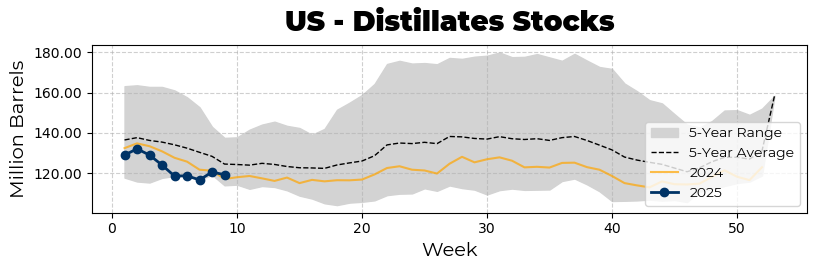

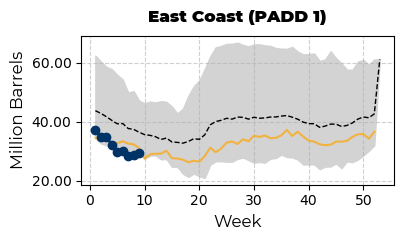

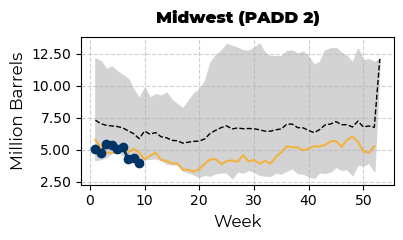

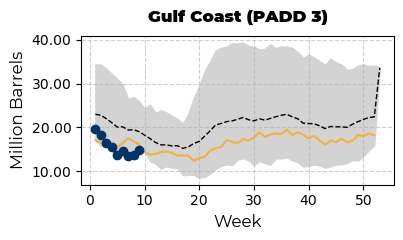

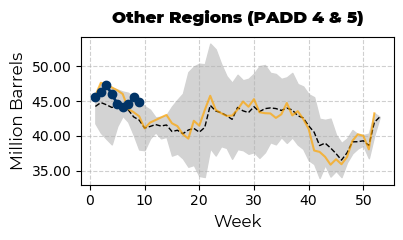

      poly_2025    poly_2024    poly_2023
1   3168.626263  3736.856255  3974.551436
2   3843.474747  3717.598379  3935.862279
3   4219.236652  3700.352613  3901.053795
4   4364.785714  3685.045846  3869.962825
5   4348.995671  3671.604965  3842.426212
6   4240.740260  3659.956859  3818.280801
7   4108.893218  3650.028417  3797.363432
8   4022.328283  3641.746525  3779.510951
9   4049.919192  3635.038072  3764.560198
10          NaN  3629.829946  3752.348018
11          NaN  3626.049035  3742.711253
12          NaN  3623.622228  3735.486746
13          NaN  3622.476412  3730.511340
14          NaN  3622.538475  3727.621878
15          NaN  3623.735306  3726.655203
16          NaN  3625.993793  3727.448158
17          NaN  3629.240823  3729.837585
18          NaN  3633.403285  3733.660328
19          NaN  3638.408067  3738.753230
20          NaN  3644.182056  3744.953133
21          NaN  3650.652142  3752.096881
22          NaN  3657.745212  3760.021315
23          NaN  3665.388154  3768

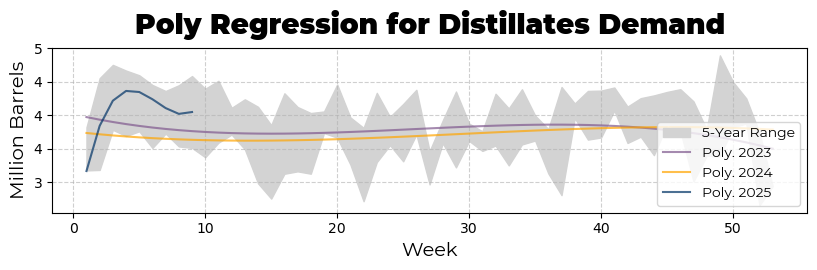

/var/folders/ym/3qhchx8d19q8jp5fvb95q9vw0000gn/T/ipykernel_2238/3130153966.py:344: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  z_score_dataset["TimeAverage"] = tenYearsRange.mean(axis=1)
/var/folders/ym/3qhchx8d19q8jp5fvb95q9vw0000gn/T/ipykernel_2238/3130153966.py:344: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  z_score_dataset["TimeAverage"] = tenYearsRange.mean(axis=1)
/var/folders/ym/3qhchx8d19q8jp5fvb95q9vw0000gn/T/ipykernel_2238/3130153966.py:344: SettingWithCopyWarning: 
A value is trying to be se

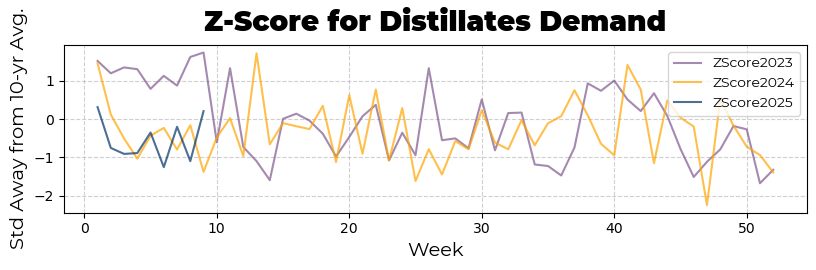

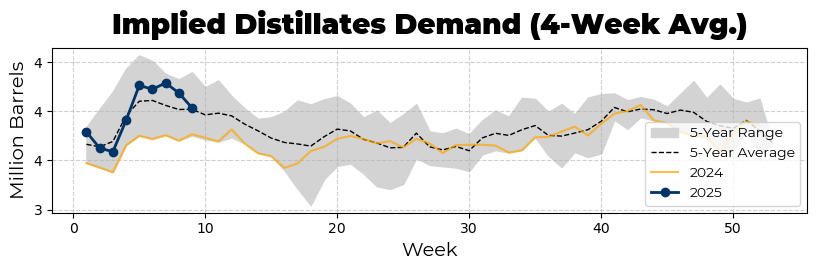

Year,2025,2024,2023,2022,2021,2020,5YrMax,5YrMin,5YrAvg
Week_Num,,,,,,,,,
1,3790.25,3472.50,3628.75,3840.25,3579.50,3690.50,3840.25,3472.50,3664.312500
2,3625.50,3428.00,3631.00,4023.75,3491.25,3456.75,4023.75,3428.00,3638.500000
3,3589.25,3379.75,3630.50,4199.50,3667.75,3500.50,4199.50,3379.75,3693.312500
4,3907.75,3654.50,3853.75,4432.00,3982.00,3712.00,4432.00,3654.50,3953.562500
5,4263.00,3750.75,3839.00,4568.75,4156.75,3921.50,4568.75,3750.75,4102.406250
6,4224.50,3718.00,3806.50,4510.00,4315.00,4080.25,4510.00,3718.00,4110.281250
7,4288.50,3757.00,3779.75,4379.75,4223.00,3915.00,4379.75,3757.00,4059.968750
8,4186.25,3701.75,3815.50,4325.00,4120.50,3969.50,4325.00,3701.75,4018.156250
9,4034.25,3766.00,3753.50,4397.75,4165.25,3896.50,4397.75,3753.50,4020.562500


In [16]:
# Export Plot 5-Yr Images
PlotData().plot_fiveyr_seasonal("us_distillates_stocks.csv", "US - Distillates Stocks", size = [8.27, 2.8])
PlotData().plot_fiveyr_seasonal("padd1_distillates_stocks.csv", "East Coast (PADD 1)", size = [4.14, 2.5], legend=False)
PlotData().plot_fiveyr_seasonal("padd2_distillates_stocks.csv", "Midwest (PADD 2)", size = [4.14, 2.5], legend=False)
PlotData().plot_fiveyr_seasonal("padd3_distillates_stocks.csv", "Gulf Coast (PADD 3)", size = [4.14, 2.5], legend=False)
PlotData().plot_fiveyr_seasonal("padd4&5_distillates_stocks.csv", "Other Regions (PADD 4 & 5)", size = [4.14, 2.5], legend=False)

# Export Poly Plot
PlotData().poly_calc("us_distillates_demand.csv", "Poly Regression for Distillates Demand",size = [8.27, 2.8])

# Export Z-Score
PlotData().z_score_calc("us_distillates_demand.csv", "Z-Score for Distillates Demand",size = [8.27, 2.8])

# Implied Demand for Distillates
PlotData().implied_fourweek_demand("us_distillates_demand.csv", "Implied Distillates Demand (4-Week Avg.)",size = [8.27, 2.8])